In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.pyplot as plt
import matplotlib as mpl
# data 
import numpy as np
# file IO
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Read Data

In [2]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data
    cols20 = hdul20[1].columns

In [3]:
# get IRAC data (unit = 'uJy')
ch1_data20  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('.', end='')
ch2_data20  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('.', end='')
ch3_data20  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('.', end='')
ch4_data20  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('.', end='')
# get ID
id_data20 = np.array(data20['ID_COSMOS2015'])
print('.', end='')

.....

In [4]:
# read file 
dataNew = adp.UnpackTable(adp.path_csv+'\\New_Lx_cat.csv')

# fix types
dataNew['ID']   = np.array(dataNew['ID'], dtype=int)
dataNew['z']    = np.array(dataNew['z'],  dtype=float)
dataNew['Lx_05_10']     = np.log10(np.array(dataNew['Lx_05_10'],     dtype=float)) # log scale
dataNew['Lx_hard_2_10'] = np.log10(np.array(dataNew['Lx_hard_2_10'], dtype=float)) # log scale

# replace C-COSMOS 2016 for X-ray selection 
id_data16 = dataNew['ID']
L0510_data16 = dataNew['Lx_05_10']

C:\Users\polar\AppData\Local\Temp\ipykernel_11976\2962619769.py:7: RuntimeWarning: divide by zero encountered in log10
  dataNew['Lx_05_10']     = np.log10(np.array(dataNew['Lx_05_10'],     dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_11976\2962619769.py:7: RuntimeWarning: invalid value encountered in log10
  dataNew['Lx_05_10']     = np.log10(np.array(dataNew['Lx_05_10'],     dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_11976\2962619769.py:8: RuntimeWarning: divide by zero encountered in log10
  dataNew['Lx_hard_2_10'] = np.log10(np.array(dataNew['Lx_hard_2_10'], dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_11976\2962619769.py:8: RuntimeWarning: invalid value encountered in log10
  dataNew['Lx_hard_2_10'] = np.log10(np.array(dataNew['Lx_hard_2_10'], dtype=float)) # log scale


In [5]:
# get redshifts
zDict_all = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

zDict_split = {
    '$0 < z \leq 1$'   : adp.GetRedshiftsInRange(zDict_all,          max=1  ),
    '$1 < z \leq 1.5$' : adp.GetRedshiftsInRange(zDict_all, min=1,   max=1.5),
    '$1.5 < z \leq 2$' : adp.GetRedshiftsInRange(zDict_all, min=1.5, max=2  ),
    '$2 < z \leq 3$'   : adp.GetRedshiftsInRange(zDict_all, min=2,   max=3  ),
    '$3 < z \leq 6$'   : adp.GetRedshiftsInRange(zDict_all, min=3           )
}

Cropped:  ['ID', 'z']
Number of redshifts: 487252
0 < z <=  1 :  212301
1 < z <=  1.5 :  96390
1.5 < z <=  2 :  57530
2 < z <=  3 :  66959
3 < z <=  99 :  44648


In [10]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                print('\t',key1,'\t',len(val1))
                
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\Lx44_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
triID_allZ = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(triID_allZ)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=627). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=466). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=584). ']
RED 	 627
GRN 	 466
BLU 	 584


# Tricolor

In [11]:
def GetAGNinZrange_Tricolor(triID, zDict_split, printLengths=True):
    tri_byZ = {}
    for key,zdata in zDict_split.items() :
        # match IDs
        onRED, ZonRED = match.match(triID['RED'], zdata['ID'])
        onGRN, ZonGRN = match.match(triID['GRN'], zdata['ID'])
        onBLU, ZonBLU = match.match(triID['BLU'], zdata['ID'])
        # get dict of ID and redshift split by tricolor
        tri_byZ[key] = {
            'RED' : { 'ID' : triID['RED'][onRED],
                      'z'  : zdata['z'][ZonRED]} ,
            'GRN' : { 'ID' : triID['GRN'][onGRN],
                      'z'  : zdata['z'][ZonGRN]} ,
            'BLU' : { 'ID' : triID['BLU'][onBLU],
                      'z'  : zdata['z'][ZonBLU]}
        }
        if(printLengths) :
            print(key, ': ', 
                  tri_byZ[key]['RED']['ID'].size, 'red,',
                  tri_byZ[key]['GRN']['ID'].size, 'green,',
                  tri_byZ[key]['BLU']['ID'].size, 'blue.'
            )
    return tri_byZ

tri_byZ = GetAGNinZrange_Tricolor(triID_allZ, zDict_split)

$0 < z \leq 1$ :  141 red, 42 green, 65 blue.
$1 < z \leq 1.5$ :  123 red, 103 green, 137 blue.
$1.5 < z \leq 2$ :  130 red, 115 green, 161 blue.
$2 < z \leq 3$ :  173 red, 166 green, 181 blue.
$3 < z \leq 6$ :  60 red, 40 green, 40 blue.


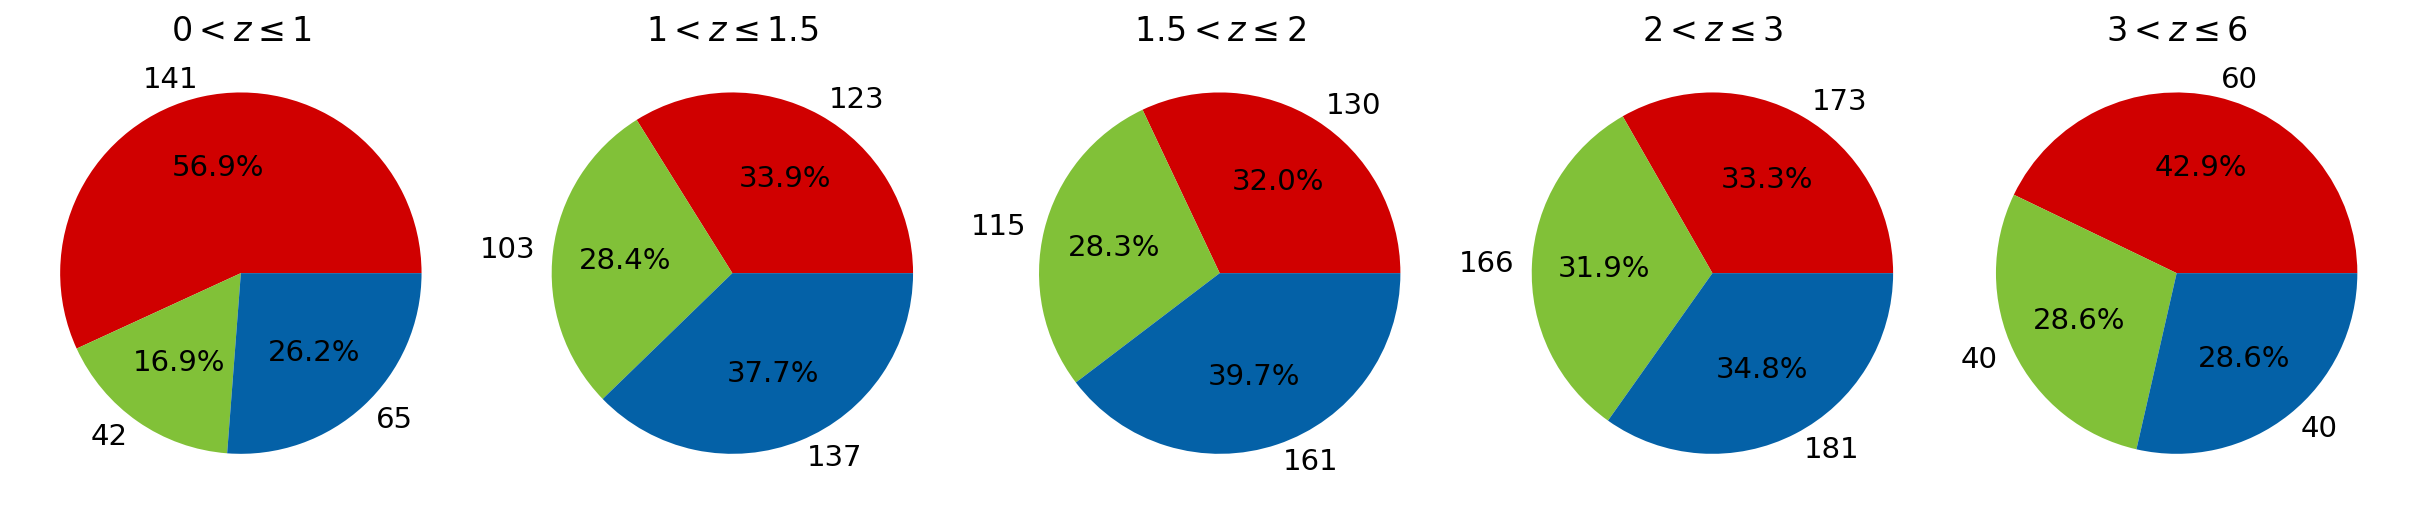

In [12]:
def TriPie_ax(ax,red,grn,blu,title=''):
    # plot pie chart on axis
    ax.pie( [red,grn,blu], 
            labels=[red,grn,blu], 
            colors=[adp.c_ir, adp.c_ir_xray, adp.c_xray],
            autopct='%1.1f%%',
            textprops={'fontsize': adp.MID + 2}
        )
    if(title):
        ax.set_title(title, pad=0)
   
def TriPie_byZ(tri_byZ, save=''):
    fig, ax = adp.ByZ_SetupFig(
        n = len(tri_byZ.keys()),
        orientVertical=False
    )
    
    # make plot for each redshift range
    i = 0
    for zrange,color in tri_byZ.items() :
        # plot on axis 
        TriPie_ax(
            ax[i],
            color['RED']['ID'].size,
            color['GRN']['ID'].size,
            color['BLU']['ID'].size,
            zrange
        )
        # increment plot
        i+=1
    adp.ByZ_FinishPlot(fig,save=save)

TriPie_byZ(tri_byZ) # , adp.path_fig + '//v2_piechart_tri_zPanels.pdf')

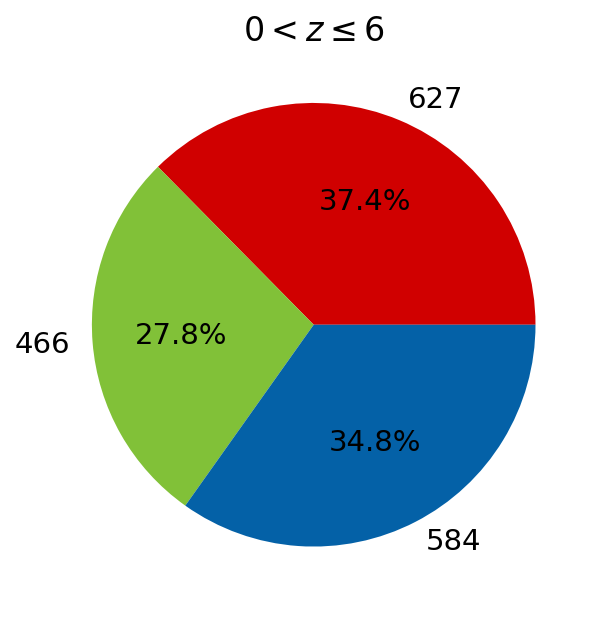

In [14]:
def OneTriPie(triID_allZ, save='') : 
    fig, ax = adp.ByZ_SetupFig(n=1)
    TriPie_ax(
            ax,
            triID_allZ['RED'].size,
            triID_allZ['GRN'].size,
            triID_allZ['BLU'].size,
            '$0 < z \leq 6$'
        )
    adp.ByZ_FinishPlot(fig,save=save)
    
OneTriPie(triID_allZ) # , adp.path_fig + '//v2_piechart_tri_zall.pdf')